## Algorithm Exploration

This notebook includes feature engineering, 
- train-test data split
- logic for handling Imbalanced dataset
- Relevant feature transformations
- Treatment of categorical variable

This notebook also demonstrates algorithm exploration part where we have applied 4 different algorithms to the training set along with setting up the pipeline for running the models.

- Logistic Regression(**Baseline**)
- Random Forest
- Gradient Boosted Tree
- Support Vector Machine
- XGBoost (**selected as a final algorithm**)

### Section 1 - Setup Environment

In [0]:
from pyspark.sql.functions import col, concat, count, countDistinct, expr, lit, length, max as pyspark_max, min as pyspark_min, mean, substring, split, sum as pyspark_sum, when, to_utc_timestamp, to_timestamp, unix_timestamp, isnan
import pandas as pd
from html import escape
from IPython.display import HTML, display as ipython_display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType, DoubleType
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from pyspark.sql.functions import substring
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, max, substring
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from sparkdl.xgboost import XgboostClassifier
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Imputer
from pyspark.ml.classification import LinearSVC as svc
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
import numpy as np
import itertools
import time
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
import seaborn as sns
from matplotlib.colors import ListedColormap


In [0]:
blob_container = "w261-container" # The name of your container created in https://portal.azure.com
storage_account = "w261storageaccount" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261scope" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

### Section 2 - Load Data

In [0]:
# Inspect the Mount's Final Project folder 
display(dbutils.fs.ls("/mnt/mids-w261/datasets_final_project"))

path,name,size
dbfs:/mnt/mids-w261/datasets_final_project/airlines/,airlines/,0
dbfs:/mnt/mids-w261/datasets_final_project/airlines_data/,airlines_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/,parquet_airlines_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_3m/,parquet_airlines_data_3m/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/,parquet_airlines_data_6m/,0
dbfs:/mnt/mids-w261/datasets_final_project/stations_data/,stations_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/,weather_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data_6_hr/,weather_data_6_hr/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data_single/,weather_data_single/,0


In [0]:
# Load joined dataset from Blob

# data_df = spark.read.parquet(f"{blob_url}/3m_join/*")
# data_df = spark.read.parquet(f"{blob_url}/3m_join_route/*")

# Load full data
full_data = True

data_df = spark.read.parquet(f"{blob_url}/full_join_route_v2/*")

display(data_df.limit(100))


### Section 3 - Define helper functions

In [0]:
# Helper function 1:
def missing_values(helper_df, sort=False):
  """
  Helper function to count number of nulls and nans in each column
  """
  df = helper_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in helper_df.dtypes if c_type not in ('timestamp')]).toPandas()
  
  if len(df) == 0:
    print("There are no missing values")
    return None
  
  if sort:
    return df.rename(index={0: 'count'}).T.sort_values("count", ascending=False)
  
  return df


In [0]:
# Helper function 2

def main():

    global eval_metrics
    global eval_predictions
    global eval_model_times
    global model_times_df
    
    eval_metrics = {}
    eval_model_times = []
    
    
f1 = 0.0
recall = 0.0
precision = 0.0
sensitivity = 0.0
specificity = 0.0
fp = 0.0
fn = 0.0
model_time = 0.0

metrics = (f1, recall, precision, sensitivity, specificity, fp, fn, model_time)
eval_metrics = {'LR': metrics}
eval_model_times = [('LR', 0.0),('RF', 0.0),('SVM', 0.0),('GB', 0.0),('XGB', 0.0)]
eval_model_times_col = ['model_name', 'model_time']
model_times_df = spark.createDataFrame(data=eval_model_times, schema=eval_model_times_col)

def print_results(predictions, model_name, model_time): 
  """
  Helper function to print evaluation metrics
  """
  tp = predictions[(predictions.departure_delay_boolean == 1) & (predictions.prediction == 1)].count()
  tn = predictions[(predictions.departure_delay_boolean == 0) & (predictions.prediction == 0)].count()
  fp = predictions[(predictions.departure_delay_boolean == 0) & (predictions.prediction == 1)].count()
  fn = predictions[(predictions.departure_delay_boolean == 1) & (predictions.prediction == 0)].count()
  total = predictions.count()
  
  recall = float(tp)/(tp+fn)
  precision = float(tp)/(tp+fp)
  f1 = (2*recall*precision)/(precision+recall)
  
  data = {'Actual-delay': [tp, fn], 'Actual-on time': [fp, tn]}
  confusion_matrix = pd.DataFrame.from_dict(data, orient='index', columns=['Predicted-delay', 'Predicted-on time'])
  
  #print("Test Area Under ROC: ", "{:.2f}".format(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})))
  #print("Test Area Under Precision-Recall Curve: ", "{:.2f}".format(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderPR'})))

  print("Sensitivity: {:.2%}".format(tp/(tp + fn)))
  print("Specificity: {:.2%}".format(tn/(tn + fp)))
  print("False positive rate: {:.2%}".format(fp/(fp + tn)))
  print("False negative rate: {:.2%}".format(fn/(tp + fn)))
  print("Recall: {:.2%}".format(recall))
  print("Precision: {:.2%}".format(precision))
  print("f1: {:.2%}".format(f1))
  
  metrics = (round(f1, 2), round(recall, 2), round(precision, 2), round(tp/(tp + fn), 2), \
             round(tn/(tn + fp), 2), round(fp/(fp + tn), 2), round(fn/(tp + fn), 2), round(model_time, 2))
  
  global eval_metrics
  global eval_model_times
  
  eval_metrics[model_name] = metrics
  eval_model_times.append(model_time)
  
  print("########### Confusion Matrix ###########")
  print(confusion_matrix)
  
def get_metrics(vector_aw, label_col_name):
  labels_and_predictions = vector_aw.select(col("prediction").cast("int"), col(label_col_name).cast("int")) \
                            .rdd.map(lambda r: (r[0],r[1]))
  
  FP = labels_and_predictions.filter(lambda x: x[0] == 1 and x[1] == 0).count()
  FN = labels_and_predictions.filter(lambda x: x[0] == 0 and x[1] == 1).count()
  TP = labels_and_predictions.filter(lambda x: x[0] == 1 and x[1] == 1).count()
  TN = labels_and_predictions.filter(lambda x: x[0] == 0 and x[1] == 0).count()
 
  accuracy = (TP + TN) / (TP + FP + TN + FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1Score = (2*(recall*precision)) / (recall + precision)
  
  return accuracy, precision, recall, f1Score
 
def print_metrics(vector_aw, label_col_name):
  accuracy, precision, recall, f1Score = get_metrics(vector_aw, label_col_name)
  
  print("Accuracy = %s" % accuracy)
  print("Precision = %s" % precision)
  print("Recall = %s" % recall)
  print("F1 Score = %s" % f1Score)
  

def save_model_times(model_name, model_time):
  global model_times_df
  
  
  
def print_model_times(model_name, model_time):
  global model_times_df
  model_times_df.show()

### Section 4 - Feature Engineering

In [0]:
# Create a feature to include the hour of the day in local time

from pyspark.sql.functions import hour

data_df = data_df.withColumn('hour',hour(data_df.actual_timestamp))

display(data_df.limit(10))

**Feature Selection**

In [0]:
#Select ML Vars - Variables for building models
split_data_df = data_df.selectExpr(
                              "cast (year as string) year",
                              "cast (month as string) month",
                              "cast (day_of_week as string) day_of_week",
                              "actual_timestamp",
                              "cast (hour as string) hour",
                              "carrier",
                              "holiday",
                              "weather_obs_prev",
                              "weather_obs_prev_2",
                              "origin",
                              "destination",
                              "departure_delay_boolean",
                              "planned_time_between_flights",
                              "cast (prev_dep_delayed_confirmed as string) prev_dep_delayed_confirmed",    
                              "distance",
                              "cast (wnd_angle_prev as int) wnd_angle_prev",                               
                              "wnd_type_prev",
                              "wnd_speed_prev_2",
                              "wnd_speed_prev",
                              "wnd_cloud_angle_prev",
                              "vis_dist_prev",
                              "vis_dist_prev_2",
                              "vis_var_prev",
                              "tmp_c_prev",
                              "dew_c_prev",
                              "route_delay",
                              "origin_arrival_delay",
                              "origin_departure_delay",
                              "dest_departure_delay",
                              "dest_arrival_delay",
                             )

display(split_data_df.limit(10))

#### 4.1. Split Data

In [0]:
### Add a cumulative rank to dataframe and then split (80-20) for time series data.

if(full_data):

  split_data_df = split_data_df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("actual_timestamp")))

# display(split_data_df)

In [0]:
# Train data is selected from the first 80% of the dataset.

if(full_data):

  train_df = split_data_df.where("rank <= .8").drop("rank","actual_timestamp")
  
#   display(train_df)

#   print(f'The train dataset has {train_df.count()} rows')

In [0]:
# Test data is selected from the last 20% of the dataset.

if(full_data):
  test_df = split_data_df.where("rank > .8").drop("rank", "actual_timestamp")
#   display(test_df)
#   print(f'The test dataset has {test_df.count()} rows')
    

In [0]:
# writing the split test and train data to blob storage
if(full_data):
  train_df.write.mode('overwrite').parquet(f"{blob_url}/original_train_data_full_v2")
  test_df.write.mode('overwrite').parquet(f"{blob_url}/original_test_data_full_v2")
 

In [0]:
# Reading the split test and train data from blob storage in case of full data

if(full_data):
  train_df = spark.read.parquet(f"{blob_url}/original_train_data_full_v2/*")
  test_df = spark.read.parquet(f"{blob_url}/original_test_data_full_v2/*")

In [0]:
# Let's verify if train data has any nulls

missing_values_df_train = missing_values(train_df)

missing_values_df2 = pd.DataFrame({
                 "features": list(missing_values_df_train.columns),
                 "number_of_nulls": list(missing_values_df_train.iloc[0])})

missing_values_df2

#### 4.2. Handling Imbalanced data - Undersampling

We used undersampling for handling imbalance in data since we have a very large dataset. 
SMOTE is another method to handle imbalanced data and has been implemented in a separate notebook located at: https://adb-6759024569771990.10.azuredatabricks.net/?o=6759024569771990#notebook/671119174920056/command/671119174920058

In [0]:
# Display proportion of labeled class
  
def get_proportion_labels(df):
  '''Function to display proportion of labeled class'''
  if verbose:
    print("In method - get_proportion_labels - displaying proportion of labeled class")
    print(display(df.groupby('departure_delay_boolean').count()))
  
  positive = df.filter(df.departure_delay_boolean == 1).count()
  negative = df.filter(df.departure_delay_boolean == 0).count()
  total = negative + positive
  if total == 0:
    raise Exception("No records found!")
  
  if positive == 0:
    raise Exception("No positive records found!")
  
  if negative == 0:
    raise Exception("No negative records found!")
    
  # there is a risk that the positive/negative classes are so imbalanced that they are non existent in the df
  # so we should guard against that case in order to avoid throwing div by 0
  np = -1 if positive == 0 else 1.0 * negative/positive
  pn = -1 if negative == 0 else 1.0 * positive/negative
  
  return 1.0 * positive/total, 1.0 * negative/total, pn, np

In [0]:
# downsample majority class dataset (i.e on-time flight data) to balance and match minority class dataset(i.e. delayed flights)

def downsample(df, min_major_class_ratio, alpha=0.99):
  '''Function to implement undersampling logic'''
  if min_major_class_ratio == -1:
    # assign default value to reduce the majority class by half
    min_major_class_ratio = 0.5
    print("In method downsample: Warning - reset min_major_class_ratio to default: {}".format(min_major_class_ratio))
    
  if verbose:
    print("Starting to downsample, negative class has {} rows and positive class has {} rows".format(df.filter(df.departure_delay_boolean == 0).count(), df.filter(df.departure_delay_boolean == 1).count()))
    
  negative = df.filter(df.departure_delay_boolean == 0).sample(False, min_major_class_ratio * alpha, seed=2021)
  positive = df.filter(df.departure_delay_boolean == 1)
  
  new_df = positive.union(negative).cache()
  if verbose:
    negative = new_df.filter(new_df.departure_delay_boolean ==0).count()
    positive = new_df.filter(new_df.departure_delay_boolean ==1).count()
    print("After downsampling, negative class has {} rows and positive class has {} rows".format(negative, positive))
  
  return new_df


In [0]:
# Execute Downsampling Process on the Training Set

verbose = True
pt, nt, pn, np = get_proportion_labels(train_df)
train_df_downsampled = downsample(train_df, pn)

In [0]:
# Assigning downsampled training dataset to be used further for modeling

train_df = train_df_downsampled


In [0]:
#Preparing final dataset for modeling
# Let's find out the datatype of the features, which will be the same for both train and test data

print("\n----Categorical columns train-----")
cat_cols = [x for (x, dataType) in train_df.dtypes if dataType == "string"]
print(cat_cols)

print("\n----Numeric columns train-----")
num_cols = [x for (x, dataType) in train_df.dtypes if (((dataType == "double") or (dataType == "int")) & (x != "departure_delay_boolean"))]
print(num_cols)

In [0]:
# Changes nulls to 9* for cat vars, not have an impact to the rest of the data since one-hot encoding
train_df = train_df.fillna('-999', subset=cat_cols)
test_df = test_df.fillna('-999', subset=cat_cols)

In [0]:
# Pipeline Functions
# Categorical Variables -> String_Indexer -> OneHotEncoding
# Numerical Variables -> Impute missing using median -> Standard Scaler
# Create vector assembler

from pyspark.ml.feature import (OneHotEncoder, StringIndexer)
string_indexer = [
    StringIndexer(inputCol=x, outputCol=x + "_StringIndexer", handleInvalid="skip")
    for x in cat_cols
]

one_hot_encoder = [
    OneHotEncoder(
        inputCols=[f"{x}_StringIndexer" for x in cat_cols],
        outputCols=[f"{x}_OneHotEncoder" for x in cat_cols],
    )
]

from pyspark.ml.feature import Imputer

imputer = [
      Imputer(inputCol=x, outputCol= x + "_Imputed").setStrategy("median")
      for x in num_cols
]

from pyspark.ml.feature import StandardScaler  

scaler_vector_assembler = VectorAssembler(inputCols = [f"{x}_Imputed" for x in num_cols], outputCol="numeric_vec")
scaler_vector_assembler.setHandleInvalid('keep')

scaler = StandardScaler(inputCol="numeric_vec", outputCol="scaled_features")

In [0]:
#Output vector assembler to be used at the modeling step, 

from pyspark.ml.feature import VectorAssembler

assembler_input = ["scaled_features"]
assembler_input += [f"{x}_OneHotEncoder" for x in cat_cols]

vector_assembler = VectorAssembler(
    inputCols=assembler_input, outputCol="VectorAssembler_features"
)

### Section 5 - ML Section

#### 5.0.  Setting up Pipeline

In [0]:
## Pipeline Stages

stages = []
stages += imputer
stages += [scaler_vector_assembler , scaler]
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]

In [0]:
# Setup Pipeline using the stages and train & test data
# label = departure_delay_boolean, features = VectorAssembler_features

from pyspark.ml import Pipeline

general_pipeline = Pipeline().setStages(stages)
pipeline_model = general_pipeline.fit(train_df)
model_data_test = pipeline_model.transform(test_df)
model_data_train = pipeline_model.transform(train_df) 

selectedcols = ["departure_delay_boolean", "VectorAssembler_features"]
model_data_train = model_data_train.select(selectedcols)
model_data_test = model_data_test.select(selectedcols)

In [0]:
# writing train and test dataset to blob storage in parquet format to be used for model algorithms

model_data_train.write.mode('overwrite').parquet(f"{blob_url}/model_train_data_full_v2")
model_data_test.write.mode('overwrite').parquet(f"{blob_url}/model_test_data_full_v2")


#### 5.1. Logistic regression

> - Logistic regresion is probably one of the most common tools in supervised learning, in particular for classification. 
> - Logistic regression is a way to model the linear relationship between one or more arbitrary independent variables and binary or categorical dependent variables. 
> - Logistic regression transforms the continuous infinite scale into a scale between 0 and 1 (Sigmoid Function or Sigmoid activation). 
> - It can be used for both inference and for prediction.

**Reading the train and test data**

In [0]:
# Reading the train and test data from blob storage for running the models

model_data_train = spark.read.parquet(f"{blob_url}/model_train_data_full_v2/*")
model_data_test = spark.read.parquet(f"{blob_url}/model_test_data_full_v2/*")


**Logistic Regression Pipeline**

In [0]:
# Setup pipeline for Logistic Regression

from pyspark.ml.classification import LogisticRegression

start_lr = time.time()

# lr = LogisticRegression(featuresCol='VectorAssembler_features',labelCol='departure_delay_boolean', regParam = 0.2, fitIntercept=True, elasticNetParam=0.0, maxIter=10, threshold = 0.6)

lr = LogisticRegression(featuresCol='VectorAssembler_features',labelCol='departure_delay_boolean', regParam = 0.001, fitIntercept=False, elasticNetParam=0.0, maxIter=50, threshold = 0.5)

stages_lr = [lr]
pipeline_lr = Pipeline(stages=stages_lr)
lr_model = pipeline_lr.fit(model_data_train)
lrPredictions = lr_model.transform(model_data_test)
print(f'lr model completed job in {time.time() - start_lr} seconds.')
lr_time_model = time.time() - start_lr

lr model completed job in 119.23501706123352 seconds.

In [0]:
lrPredictions.write.mode('overwrite').parquet(f"{blob_url}/lrPredictions_explore")

# eval_predictions.write.mode('overwrite').parquet(f"{blob_url}/eval_predictions")
# eval_times.write.mode('overwrite').parquet(f"{blob_url}/eval_predictions")


**Logistic Regression Model Evaluation**

In [0]:

lrPredictions = spark.read.parquet(f"{blob_url}/lrPredictions_explore/*")

# Model Evaluation with scikit learn
y_true_lr = lrPredictions.select(['departure_delay_boolean']).collect()
y_pred_lr = lrPredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lr, y_pred_lr))
print(confusion_matrix(y_true_lr, y_pred_lr))

precision recall f1-score support

 0.0 0.90 0.73 0.81 5209992
 1.0 0.38 0.66 0.48 1292004

 accuracy 0.72 6501996
 macro avg 0.64 0.70 0.64 6501996
weighted avg 0.79 0.72 0.74 6501996

[[3821015 1388977]
 [ 441096 850908]]

In [0]:
# Print results with helper function

print_results(lrPredictions, 'LR', lr_time_model)

Sensitivity: 65.86%
Specificity: 73.34%
False positive rate: 26.66%
False negative rate: 34.14%
Recall: 65.86%
Precision: 37.99%
f1: 48.18%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 850908 441096
Actual-on time 1388977 3821015

In [0]:
# eval_times = spark.createDataFrame(eval_model_times, FloatType())
# eval_times.write.mode('overwrite').parquet(f"{blob_url}/eval_times_explore")

Out[12]:

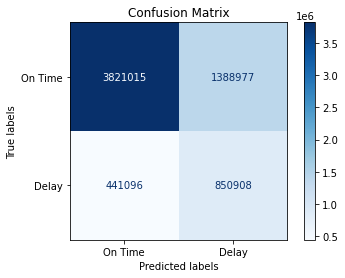

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lr = confusion_matrix(y_true_lr, y_pred_lr)
cm_lr_display = ConfusionMatrixDisplay(cm_lr, display_labels=['On Time', 'Delay'])
cm_lr_display.plot(cmap='Blues', values_format='d')
cm_lr_display.ax_.set(title='Confusion Matrix')
cm_lr_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')


#### 5.2. Random Forest Classifier

> - Random Forest is a supervised learning algorithm that can be used for classification as well as regression. 
> - Random forest consists of a large number of individual decision tress that operate as an ensemble (or group) of decision trees. 
> - Initially, it selects a random subset of the total training data, then it fits a decision tree to that subset of the data, creating a "forest" of multiple decision trees all trained on slightly different versions of the training data.
> - When it comes time to make predictions, each new data point is run through all of the trees in the forest, with each tree getting a single vote as to it's class. The class with the highest votes is the prediction.

**Random Forest Pipeline**

In [0]:
# # Random Forest Hyperparameter tuning using an exhastive search
# from pyspark.ml.classification import RandomForestClassifier
# RF_NUM_TREES = [100, 150, 200]
# RF_MAX_DEPTH = [5, 10, 15]
# RF_NUM_BINS = 32
 
# #f1scores and best_params consist of (NUM_TREES, MAX_DEPTH, f1Score)
# f1scores = []
# best_f1score = 0
# best_params = []
 
# for tr in RF_NUM_TREES:
#   for dp in RF_MAX_DEPTH:
#     #Cross-validation for time series below.
#     f1score_total = 0
      
#     rf = RandomForestClassifier(labelCol='departure_delay_boolean',
#                           featuresCol='VectorAssembler_features',
#                           maxDepth= dp,
#                           numTrees = tr,
#                           maxBins = RF_NUM_BINS,
#                           impurity = "gini",
#                           seed = 123)

#     #Fit the model
#     rfModel = rf.fit(model_data_train) 

#     # Test on test set
#     rfPredictions = rfModel.transform(model_data_test)
#     accuracy, precision, recall, f1score = get_metrics(rfPredictions, "departure_delay_boolean")
# #    f1score_total += f1score

#   f1scores.append((tr, dp, f1score))
#   if (f1score > best_f1score):
#     best_f1score = f1score
#     best_params = (tr, dp, f1score)

#   print(f"Trees param: {tr}, Depth param: {dp}, f1score: {f1score:0.4f}.")

# print(f"Best param: {best_params}")

In [0]:
# from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

# added impurity="gini", maxDepth=15, numTrees=200, maxBins=32, seed=123, / 5 100
start_rf = time.time()
rf = RandomForestClassifier(labelCol='departure_delay_boolean',
                            featuresCol='VectorAssembler_features',
                            maxDepth= 10,
                            numTrees = 50,
                            maxBins = 32,
                            impurity = "gini",
                            seed = 123)

stages_rf = [rf]
pipeline_rf = Pipeline(stages=stages_rf)
rf_model = pipeline_rf.fit(model_data_train)
rfPredictions = rf_model.transform(model_data_test)

print(f'rf model completed job in {time.time() - start_rf} seconds.')
rf_time_model = time.time() - start_rf

rf model completed job in 1027.4206461906433 seconds.

In [0]:
rfPredictions.write.mode('overwrite').parquet(f"{blob_url}/rfPredictions_explore")

**Random Forest Model Evaluation**

In [0]:
# Model Evaluation

rfPredictions = spark.read.parquet(f"{blob_url}/rfPredictions_explore/*")

eval_accuracy = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="precision")
eval_recall = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="recall")
evaluator = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="f1")
evaluator.evaluate(rfPredictions)

# Model Evaluation with scikit learn
y_true_rf = rfPredictions.select(['departure_delay_boolean']).collect()
y_pred_rf = rfPredictions.select(['prediction']).collect()

# Print metrics

print(classification_report(y_true_rf, y_pred_rf))
print(confusion_matrix(y_true_rf, y_pred_rf))

precision recall f1-score support

 0.0 0.89 0.76 0.82 5209992
 1.0 0.40 0.63 0.49 1292004

 accuracy 0.74 6501996
 macro avg 0.64 0.69 0.65 6501996
weighted avg 0.79 0.74 0.76 6501996

[[3971690 1238302]
 [ 481590 810414]]

In [0]:
# print results with helper function
print_results(rfPredictions, 'RF', rf_time_model)

Sensitivity: 62.73%
Specificity: 76.23%
False positive rate: 23.77%
False negative rate: 37.27%
Recall: 62.73%
Precision: 39.56%
f1: 48.52%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 810414 481590
Actual-on time 1238302 3971690

Out[18]:

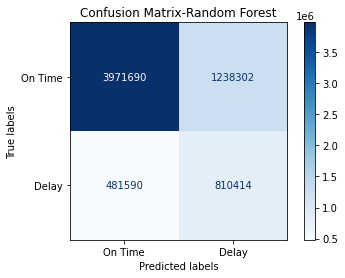

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot confusion matrix

cm_rf = confusion_matrix(y_true_rf, y_pred_rf)
cm_rf_display = ConfusionMatrixDisplay(cm_rf, display_labels=['On Time', 'Delay'])
cm_rf_display.plot(cmap='Blues', values_format='d')
cm_rf_display.ax_.set(title='Confusion Matrix-Random Forest')
cm_rf_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

#### 5.3. Support Vector Machine

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

We used the **LinearSVC** class in PySpark because we are doing support vector classification - and not regression. It is important to note that LinearSVC in Pyspark optimizes the Hinge Loss using the OWLQN optimizer. It only supports L2 regularization currently.

**Comparison of SVC with other models:**

1) SVC vs Random Forest or Gradient Boosted tree 

> - SVM requires more computation time for achieving almost the same accuracy as with other classifiers such as Random forest.
> - Random Forest is intrinsically suited for multiclass problems, while SVM is intrinsically two-class. For multiclass problem, while using SVM, it is needed to reduce it into multiple binary classification problems.
> - Random Forest works well with a mixture of numerical and categorical features, even when features are on the various scales. Basically, with Random Forest we can use data as they are. SVM maximizes the "margin" and thus relies on the concept of "distance" between different points. In that case it falls on us to decide if "distance" is meaningful. As a consequence, in SVM, one-hot encoding for categorical features is a must-do. Further, min-max or other scaling is highly recommended at preprocessing step for SVM.
> - For a classification problem like the one that we built our model on, Random Forest gives the probability of belonging to class whereas SVM gives the distance to the boundary, Hence, for those problems, SVM generally performs better than Random Forest. But the caveat here is that, for SVM, we still need to convert it to probability somehow if we need probability.

2) SVC vs Logistic Regression
Comparing SVC vs Logistic Regression, SVC tries to find an optimal hyperplane rather than focusing on maximizing the probability of the data. It is less prone to overfitting compared to logistic regression, however, may take longer to train. We expected SVM to perform at par or better than logistic regression.

##### 5.3.1. SVM Model Pipeline

In [0]:
from pyspark.ml.classification import LinearSVC
start_svc = time.time()
lsvc = LinearSVC(featuresCol='VectorAssembler_features',
                 labelCol='departure_delay_boolean',
                 maxIter=100, regParam=0.2, tol=1e-05,
                 threshold=0.0001, aggregationDepth=2 )

stages_lsvc = [lsvc]
pipeline_lsvc = Pipeline(stages=stages_lsvc)
lsvc_model = pipeline_lsvc.fit(model_data_train)
lsvcPredictions = lsvc_model.transform(model_data_test)
print(f'svc model completed job in {time.time() - start_svc} seconds.')
svc_time_model = time.time() - start_svc

svc model completed job in 166.8932294845581 seconds.

In [0]:
lsvcPredictions.write.mode('overwrite').parquet(f"{blob_url}/lsvcPredictions_explore")

In [0]:
lsvcPredictions = spark.read.parquet(f"{blob_url}/lsvcPredictions_explore/*")

# Model Evaluation with scikit learn
y_true_lsvc = lsvcPredictions.select(['departure_delay_boolean']).collect()
y_pred_lsvc = lsvcPredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lsvc, y_pred_lsvc))
print(confusion_matrix(y_true_lsvc, y_pred_lsvc))


precision recall f1-score support

 0.0 0.88 0.75 0.81 5209992
 1.0 0.37 0.58 0.45 1292004

 accuracy 0.72 6501996
 macro avg 0.62 0.67 0.63 6501996
weighted avg 0.78 0.72 0.74 6501996

[[3910203 1299789]
 [ 538199 753805]]

In [0]:
print_results(lsvcPredictions, 'SVM', svc_time_model)

Sensitivity: 58.34%
Specificity: 75.05%
False positive rate: 24.95%
False negative rate: 41.66%
Recall: 58.34%
Precision: 36.71%
f1: 45.06%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 753805 538199
Actual-on time 1299789 3910203

In [0]:
# eval_times = spark.createDataFrame(eval_model_times, FloatType())
# eval_times.write.mode('overwrite').parquet(f"{blob_url}/eval_times_explore")

Out[24]:

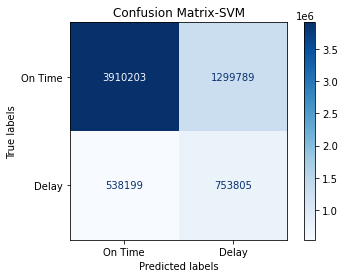

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
#Plot Confusion Matrix

cm_lsvc = confusion_matrix(y_true_lsvc, y_pred_lsvc)
cm_lsvc_display = ConfusionMatrixDisplay(cm_lsvc, display_labels=['On Time', 'Delay'])
cm_lsvc_display.plot(cmap='Blues', values_format='d')
cm_lsvc_display.ax_.set(title='Confusion Matrix-SVM')
cm_lsvc_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

In [0]:
print(eval_metrics)

{'LR': (0.48, 0.66, 0.38, 0.66, 0.73, 0.27, 0.34, 119.24), 'RF': (0.49, 0.63, 0.4, 0.63, 0.76, 0.24, 0.37, 1027.42), 'SVM': (0.45, 0.58, 0.37, 0.58, 0.75, 0.25, 0.42, 166.89)}

In [0]:
pd_df = pd.DataFrame(data=eval_metrics)
pd_df.sort_values(by=0, axis=1, ascending=True, inplace=True)
pd_df.insert(0, 'Metric', ('F1', 'Recall', 'Precision', 'Sensitivity', 'Specificity', 'FP', 'FN', 'Time'))
column_names = ['Metric', 'SVM', 'RF', 'LR']

display(HTML(pd_df.to_html(index=False)))

Metric,SVM,LR,RF
F1,0.45,0.48,0.49
Recall,0.58,0.66,0.63
Precision,0.37,0.38,0.40
Sensitivity,0.58,0.66,0.63
Specificity,0.75,0.73,0.76
FP,0.25,0.27,0.24
FN,0.42,0.34,0.37
Time,166.89,119.24,1027.42


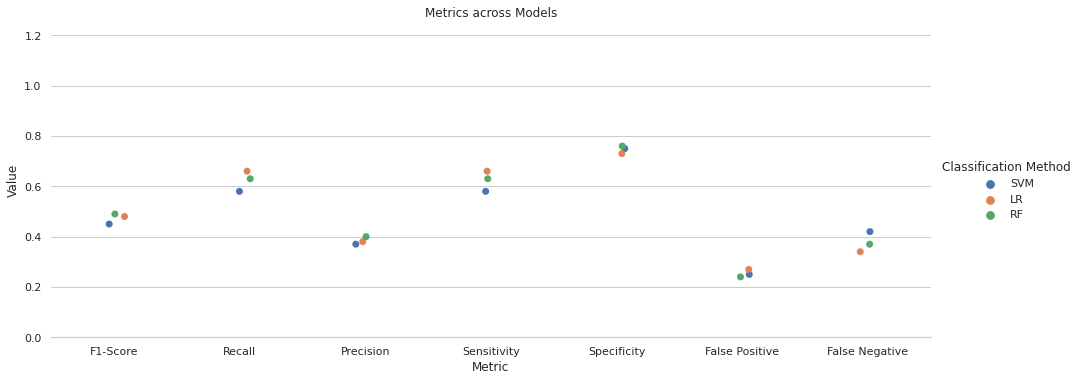

In [0]:
import numpy as np

df1 = data=pd_df.iloc[0:7,0:4]

df1 = df1.melt('Metric', var_name='Classification Method',  value_name='Value')

N = 500
# Construct the colormap
current_palette = sns.color_palette("muted", n_colors=11)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
colors = np.random.randint(0, 11, N)

sns.set_theme(style="whitegrid")

g = sns.catplot(x="Metric", y="Value", hue='Classification Method', data=df1, marker='o', c=colors, cmap=cmap, aspect=2.6, s=7, facecolors='none', edgecolors='r')
(g.set_axis_labels("Metric", "Value")
  .set_xticklabels(['F1-Score', 'Recall', 'Precision', 'Sensitivity', 'Specificity', 'False Positive', 'False Negative'])
  .set_titles("{col_name} {col_var}")
  .set(ylim=(0, 1.25))
  .despine(left=True))
plt.title("Metrics across Models")
plt.show()

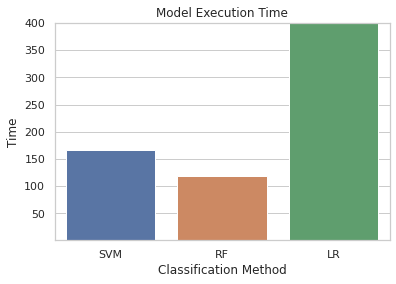

In [0]:
df2 = pd_df.iloc[7:8,0:4]
df2.columns = column_names
df2 = df2.melt('Metric', var_name='Classification Method',  value_name='Time')
g = sns.barplot(x="Classification Method", y="Time", data=df2)
(g.set(ylim=(0.5, 400.0)))
plt.title("Model Execution Time")
plt.show()


#### 5.4. Gradient Boosted Trees

About Gradient Boosted Trees

Gradient Boosted Trees (GBTs) is a learning algorithm for classification. 
> - It supports binary labels, as well as both continuous and categorical features.
> - Like Random Forest, GBT is also one of ensembling methods that combine the outputs from individual trees. However, unlike random forest, GBT use a method called `boosting` that combines weak learners sequentially so that each tree corrects the error from the previous one .
> - After each full cycle of decision tree build, the sampled dataset is weighted - misclassified data increases it weights to emphasize the most difficult cases so that when the next decision tree is built the weighted data is used, therefore subsequent learners will focus more on mis-classified data during training.
> - Random forest creates independant decision trees and combines them in parallel to calculate the average result at the end, whereas GBT combines result along the way.
> - GBT has a lot of model capacity so they can handle very complex relationships and decision boundaries, however, as with all models with high capacity, this can lead to overfitting very quickly

##### 5.4.1. Cross Validation - GBT

We decided to use cross-validation for `Gradient Boosted Tree model` in order to obtain the best hyperparameters to use when training models on full training dataset. Since cross-validation technique is computationally expensive. we decided to use a small sample of the training data to do cross-validation.

In [0]:
# Taking small sample of train data
model_data_gbt_train_sample = model_data_train.sample(0.001)

In [0]:
# Cross Validation

gb = GBTClassifier(labelCol="departure_delay_boolean", featuresCol="VectorAssembler_features")
gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5, 10])
             .addGrid(gb.maxBins, [10, 1000, 5000])
             .addGrid(gb.maxIter, [10, 15, 20])
             .addGrid(gb.minInstancesPerNode, [1, 5, 10])
             .addGrid(gb.minInfoGain, [0.0,0.001])
             .addGrid(gb.stepSize, [0.1,0.2,0.5])                 
             .build())               

In [0]:
# Create 3-fold CrossValidator

gbevaluator = MulticlassClassificationEvaluator(labelCol='departure_delay_boolean', metricName='f1')
gbcv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbevaluator,
                      numFolds = 3)

##### 5.4.2. GBT Parameter Hypertuning

In [0]:
# GBT Parameter Hypertuning - only to be run for parameter hypertuning

# gbcvModel = gbcv.fit(model_data_gbt_train_sample)
# print(gbcvModel)

Based on the result from cross-validation, we opted for maxDepth=10, maxBins=10, and maxIter=10, which is a combination of hyperparameters that achieved the highest average f1 score during the cross-validation process. These params have been used for running GBT algorithm below:

##### 5.4.3. GBT Algorithm

##### 5.4.4. GBT Model Pipeline

In [0]:
# model_data_train = spark.read.parquet(f"{blob_url}/model_train_data_full_v2_unscaled/*")
# model_data_test = spark.read.parquet(f"{blob_url}/model_test_data_full_v2_unscaled/*")


In [0]:
# Reference used for building Gradient Boosted tree model: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html

# Build a gradient boosted tree model

start_gbt = time.time()
gbt = GBTClassifier(featuresCol='VectorAssembler_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=5,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=15, 
              )

# Setup pipeline
stages_gbtClassifier = [gbt]
pipeline_gbt = Pipeline(stages=stages_gbtClassifier)

# Train the GBT model
gbt_model = pipeline_gbt.fit(model_data_train)

gbpredictions = gbt_model.transform(model_data_test)

print(f'gbt model completed job in {time.time() - start_gbt} seconds.')
gbt_time_model = time.time() - start_gbt

gbt model completed job in 2434.910961866379 seconds.

In [0]:
gbpredictions.write.mode('overwrite').parquet(f"{blob_url}/gbpredictions_explore")

##### 5.4.5. GBT Model Evaluation

In [0]:
gbpredictions = spark.read.parquet(f"{blob_url}/gbpredictions_explore/*")

In [0]:
# Model Evaluation

eval_accuracy = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="precision")
eval_recall = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="recall")

evaluator = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="f1")
evaluator.evaluate(gbpredictions)

# Model Evaluation with scikit learn
y_true_gbt = gbpredictions.select(['departure_delay_boolean']).collect()
y_pred_gbt = gbpredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_gbt, y_pred_gbt))
print(confusion_matrix(y_true_gbt, y_pred_gbt))

precision recall f1-score support

 0.0 0.89 0.79 0.84 5209992
 1.0 0.42 0.62 0.50 1292004

 accuracy 0.76 6501996
 macro avg 0.66 0.71 0.67 6501996
weighted avg 0.80 0.76 0.77 6501996

[[4107052 1102940]
 [ 487084 804920]]

In [0]:
# print results with helper function

print_results(gbpredictions, 'GB', gbt_time_model)


Sensitivity: 62.30%
Specificity: 78.83%
False positive rate: 21.17%
False negative rate: 37.70%
Recall: 62.30%
Precision: 42.19%
f1: 50.31%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 804920 487084
Actual-on time 1102940 4107052

Out[39]:

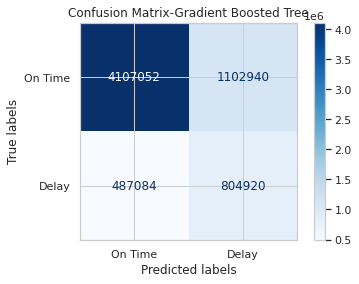

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot Confusion Matrix

cm_gbt = confusion_matrix(y_true_gbt, y_pred_gbt)
cm_gbt_display = ConfusionMatrixDisplay(cm_gbt, display_labels=['On Time', 'Delay'])
cm_gbt_display.plot(cmap='Blues', values_format='d')
cm_gbt_display.ax_.set(title='Confusion Matrix-Gradient Boosted Tree')
cm_gbt_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

In [0]:
#print_results(lsvcPredictions, 'GB', svc_time_model)

In [0]:
# eval_times = spark.createDataFrame(eval_model_times, FloatType())
# eval_times.write.mode('overwrite').parquet(f"{blob_url}/eval_times_explore")

In [0]:
print(eval_metrics)

{'LR': (0.48, 0.66, 0.38, 0.66, 0.73, 0.27, 0.34, 119.24), 'RF': (0.49, 0.63, 0.4, 0.63, 0.76, 0.24, 0.37, 1027.42), 'SVM': (0.45, 0.58, 0.37, 0.58, 0.75, 0.25, 0.42, 166.89), 'GB': (0.5, 0.62, 0.42, 0.62, 0.79, 0.21, 0.38, 2434.91)}

In [0]:
pd_df = pd.DataFrame(data=eval_metrics)
pd_df.sort_values(by=0, axis=1, ascending=True, inplace=True)
pd_df.insert(0, 'Metric', ('F1', 'Recall', 'Precision', 'Sensitivity', 'Specificity', 'FP', 'FN', 'Time'))
column_names = ['Metric', 'GB', 'RF', 'SVC', 'RF']

display(HTML(pd_df.to_html(index=False)))


Metric,SVM,LR,RF,GB
F1,0.45,0.48,0.49,0.50
Recall,0.58,0.66,0.63,0.62
Precision,0.37,0.38,0.40,0.42
Sensitivity,0.58,0.66,0.63,0.62
Specificity,0.75,0.73,0.76,0.79
FP,0.25,0.27,0.24,0.21
FN,0.42,0.34,0.37,0.38
Time,166.89,119.24,1027.42,2434.91


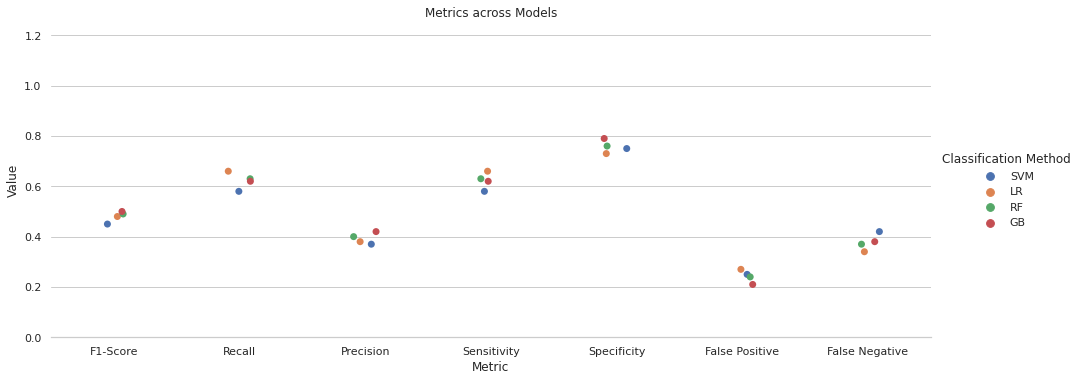

In [0]:
df1 = data=pd_df.iloc[0:7,0:5]

df1 = df1.melt('Metric', var_name='Classification Method',  value_name='Value')

N = 500
# Construct the colormap
current_palette = sns.color_palette("muted", n_colors=11)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
colors = np.random.randint(0, 11, N)

sns.set_theme(style="whitegrid")

g = sns.catplot(x="Metric", y="Value", hue='Classification Method', data=df1, marker='o', c=colors, cmap=cmap, aspect=2.6, s=7, facecolors='none', edgecolors='r')
(g.set_axis_labels("Metric", "Value")
  .set_xticklabels(['F1-Score', 'Recall', 'Precision', 'Sensitivity', 'Specificity', 'False Positive', 'False Negative'])
  .set_titles("{col_name} {col_var}")
  .set(ylim=(0, 1.25))
  .despine(left=True))
plt.title("Metrics across Models")
plt.show()



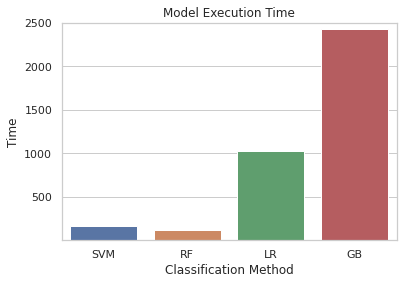

In [0]:
column_names = ['Metric', 'SVM', 'RF', 'LR', 'GB']
df2 = pd_df.iloc[7:8,0:5]
df2.columns = column_names
df2 = df2.melt('Metric', var_name='Classification Method',  value_name='Time')
g = sns.barplot(x="Classification Method", y="Time", data=df2)
(g.set(ylim=(0.5, 2500.0)))
plt.title("Model Execution Time")
plt.show()



#### 5.5. XGBoost

In [0]:
xgb = XgboostClassifier(featuresCol='VectorAssembler_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=15,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=10,
              missing = 0.0,
              n_estimators = 200 
              )

# Setup pipeline
stages_xgbClassifier = [xgb]
pipeline_xgb = Pipeline(stages=stages_xgbClassifier)


In [0]:
start_xgb = time.time()

# Train the XGB model
xgb_model = pipeline_xgb.fit(model_data_train)

xgbpredictions = xgb_model.transform(model_data_test)

xgb_time_model = time.time() - start_xgb

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-2297543790378339> in <module> 
 2 
 3 # Train the XGB model 
 ----> 4 xgb_model = pipeline_xgb . fit ( model_data_train ) 
 5 
 6 xgbpredictions = xgb_model . transform ( model_data_test ) 

 /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py in patched_method (self, *args, **kwargs) 
 28 call_succeeded = False 
 29 try : 
 ---> 30 result = original_method ( self , * args , ** kwargs ) 
 31 call_succeeded = True 
 32 return result

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 159 return self . copy ( params ) . _fit ( dataset ) 
 160 else : 
 --> 161 return self . _fit ( dataset ) 
 162 else : 
 163 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/ml/pipeline.py in _fit (self, dataset) 
 112 dataset = stage . transform ( dataset ) 
 113 else : # must be an Estimator 
 --> 114 model = stage . fit ( dataset ) 
 115 transformers . append ( model ) 
 116 if i < indexOfLastEstimator : 

 /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py in patched_method (self, *args, **kwargs) 
 28 call_succeeded = False 
 29 try : 
 ---> 30 result = original_method ( self , * args , ** kwargs ) 
 31 call_succeeded = True 
 32 return result

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 159 return self . copy ( params ) . _fit ( dataset ) 
 160 else : 
 --> 161 return self . _fit ( dataset ) 
 162 else : 
 163 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/databricks/utils/instrumentation.py in wrapper (self, *args, **kwargs) 
 40 try : 
 41 start_time = time . time ( ) 
 ---> 42 return_val = func ( self , * args , ** kwargs ) 
 43 except Exception as e : 
 44 duration = ( time . time ( ) - start_time ) * 1000 

 /databricks/.python_edge_libs/sparkdl/xgboost/xgboost_core.py in _fit (self, dataset) 
 574 
 575 # Train on 1 remote worker, return the string of the serialized model 
 --> 576 result_ser_model_string = dataset . repartition ( 1 ) \ 
 577 . mapInPandas ( train_func , schema = 'model_string string' ) . collect ( ) [ 0 ] [ 0 ] 
 578 

 /databricks/spark/python/pyspark/sql/dataframe.py in collect (self) 
 695 # Default path used in OSS Spark / for non-DF-ACL clusters: 
 696 with SCCallSiteSync ( self . _sc ) as css : 
 --> 697 sock_info = self . _jdf . collectToPython ( ) 
 698 return list ( _load_from_socket ( sock_info , BatchedSerializer ( PickleSerializer ( ) ) ) ) 
 699 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 115 def deco ( * a , ** kw ) : 
 116 try : 
 --> 117 return f ( * a , ** kw ) 
 118 except py4j . protocol . Py4JJavaError as e : 
 119 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling o18282.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 548.0 failed 4 times, most recent failure: Lost task 0.3 in stage 548.0 (TID 2447) (10.0.128.7 executor 5): ExecutorLostFailure (executor 5 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likel

In [0]:
xgbpredictions.write.mode('overwrite').parquet(f"{blob_url}/xgbpredictions_explore")

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2297543790378340> in <module> 
 ----> 1 xgbpredictions . write . mode ( 'overwrite' ) . parquet ( f"{blob_url}/xgbpredictions_explore" ) 

 NameError : name 'xgbpredictions' is not defined

In [0]:
xgbpredictions = spark.read.parquet(f"{blob_url}/xgbpredictions_explore/*")

In [0]:
# Model Evaluation

eval_accuracy = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="precision")
eval_recall = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="recall")

evaluator = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="f1")
evaluator.evaluate(xgbpredictions)





Out[50]: 0.7907348236371323

In [0]:
# Model Evaluation with scikit learn
y_true_xgb = xgbpredictions.select(['departure_delay_boolean']).collect()
y_pred_xgb = xgbpredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_xgb, y_pred_xgb))
print(confusion_matrix(y_true_xgb, y_pred_xgb))

Error while obtaining a new communication channel

In [0]:
# Plot Confusion Matrix

cm_xgb = confusion_matrix(y_true_xgb, y_pred_xgb)
cm_xgb_display = ConfusionMatrixDisplay(cm_xgb, display_labels=['On Time', 'Delay'])
cm_xgb_display.plot(cmap='Blues', values_format='d')
cm_xgb_display.ax_.set(title='Confusion Matrix-XGB')
cm_xgb_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2297543790378344> in <module> 
 1 # Plot Confusion Matrix 
 2 
 ----> 3 cm_xgb = confusion_matrix ( y_true_xgb , y_pred_xgb ) 
 4 cm_xgb_display = ConfusionMatrixDisplay ( cm_xgb , display_labels = [ 'On Time' , 'Delay' ] ) 
 5 cm_xgb_display . plot ( cmap = 'Blues' , values_format = 'd' ) 

 NameError : name 'confusion_matrix' is not defined

In [0]:
print_results(xgbpredictions, 'XGB', xgb_time_model)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2297543790378345> in <module> 
 ----> 1 print_results ( xgbpredictions , 'XGB' , xgb_time_model ) 

 NameError : name 'print_results' is not defined

In [0]:
pd_df = pd.DataFrame(data=eval_metrics)
pd_df.sort_values(by=0, axis=1, ascending=True, inplace=True)
pd_df.insert(0, 'Metric', ('F1', 'Recall', 'Precision', 'Sensitivity', 'Specificity', 'FP', 'FN', 'Time'))
column_names = ['Metric', 'GB', 'RF', 'SVC', 'RF', 'XGB']

display(HTML(pd_df.to_html(index=False)))

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2297543790378346> in <module> 
 ----> 1 pd_df = pd . DataFrame ( data = eval_metrics ) 
 2 pd_df . sort_values ( by = 0 , axis = 1 , ascending = True , inplace = True ) 
 3 pd_df . insert ( 0 , 'Metric' , ( 'F1' , 'Recall' , 'Precision' , 'Sensitivity' , 'Specificity' , 'FP' , 'FN' , 'Time' ) ) 
 4 column_names = [ 'Metric' , 'GB' , 'RF' , 'SVC' , 'RF' , 'XGB' ] 
 5 

 NameError : name 'pd' is not defined

In [0]:
df1 = data=pd_df.iloc[0:7,0:6]

df1 = df1.melt('Metric', var_name='Classification Method',  value_name='Value')

N = 500
# Construct the colormap
current_palette = sns.color_palette("muted", n_colors=11)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
colors = np.random.randint(0, 11, N)

sns.set_theme(style="whitegrid")

g = sns.catplot(x="Metric", y="Value", hue='Classification Method', data=df1, marker='o', c=colors, cmap=cmap, aspect=2.6, s=7, facecolors='none', edgecolors='r')
(g.set_axis_labels("Metric", "Value")
  .set_xticklabels(['F1-Score', 'Recall', 'Precision', 'Sensitivity', 'Specificity', 'False Positive', 'False Negative'])
  .set_titles("{col_name} {col_var}")
  .set(ylim=(0, 1.25))
  .despine(left=True))
plt.title("Metrics across Models")
plt.show()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2297543790378347> in <module> 
 ----> 1 df1 = data = pd_df . iloc [ 0 : 7 , 0 : 6 ] 
 2 
 3 df1 = df1 . melt ( 'Metric' , var_name = 'Classification Method' , value_name = 'Value' ) 
 4 
 5 N = 500 

 NameError : name 'pd_df' is not defined

In [0]:
column_names = ['Metric', 'SVM', 'LR', 'RF', 'GB', 'XGB']
df2 = pd_df.iloc[7:8,0:6]
df2.columns = column_names
df2 = df2.melt('Metric', var_name='Classification Method',  value_name='Time')
g = sns.barplot(x="Classification Method", y="Time", data=df2)
(g.set(ylim=(0.5, 2500.0)))
plt.title("Model Execution Time")
plt.show()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2297543790378348> in <module> 
 1 column_names = [ 'Metric' , 'SVM' , 'LR' , 'RF' , 'GB' , 'XGB' ] 
 ----> 2 df2 = pd_df . iloc [ 7 : 8 , 0 : 6 ] 
 3 df2 . columns = column_names
 4 df2 = df2 . melt ( 'Metric' , var_name = 'Classification Method' , value_name = 'Time' ) 
 5 g = sns . barplot ( x = "Classification Method" , y = "Time" , data = df2 ) 

 NameError : name 'pd_df' is not defined